# Decision tree

Throughout the following exercises, you will learn to construct and interpret a decision tree model with scikit-learn. Before starting on this programming exercise, we strongly recommend watching the video lecture and completing the IVQ for the associated topics.

This notebook contains the code used in two instructional videos from Week 4: Tree-based modeling. Start from the beginning to follow along with the video, Build a decision tree with Python.

All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook. 

Topics of focus include:

* Relevant import statements
* Selecting an evaluation metric
* Encoding of categorical features as dummies
* Stratification during data splitting
* Fitting a model
* Model evaluation using precision, recall, and F1 score
* Plotting the decision tree and examining its splits



As we move forward, you can find instructions on how to install required libraries as they arise in this notebook. 

## Modeling objective

The modeling objective is to build and test a decision tree model that uses banking data to predict whether a customer will churn. If a customer churns, it means they left the bank and took their business elsewhere. If we can predict customers who are likely to churn, we can take measures to retain them before they do. These measures could be promotions, discounts, or other incentives to boost customer satisfaction and, therefore, retention.

### Model design and target variable

Our data dictionary shows that there is a column called `Exited`. This is a Boolean value that indicates whether or not a customer left the bank (0 = did not leave, 1 = did leave). This will be our target variable. In other words, for each customer, our model should predict whether they should have a 0 or a 1 in the `Exited` column.

This is a classification task because we are trying to predict on a binary class. Therefore, we will use a `DecisionTreeClassifier` model.

### A note on modeling workflow and model selection

This notebook is used together with other notebooks in this course that model the same data. Because of this, we will build all of our models across all of these notebooks, and model selection will take place in the final notebook. The champion model will be the one that performs best on the validation data. Only this final model will be evaluated using the test data. 

This approach has a limitation. We are using the same data to tune the hyperparameters as we are using to perform model selection. This risks potentially overfitting the model to the validation data. 

Ideally, with enough time and data, we'd tune the models' hyperparameters, then score all the models on _separate_ validation data and perform model selection based on these scores. Finally, the champion model would be scored on the test holdout data to get an estimate of how the model can be expected to perform on new, unseen data.

<a id='1'></a>
# Build a decision tree with Python


## Import statements

Before we begin with the exercises and analyzing the data, we need to import all libraries and extensions required for this programming exercise. Throughout the course, we will be using numpy and pandas for operations, and matplotlib for plotting. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# This function displays the splits of the tree
from sklearn.tree import plot_tree

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report

## Read in the data

In [4]:
# Read in data
file = 'Churn_Modelling.csv'
df_original = pd.read_csv(file)
df_original.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Examine the data

At this point in a typical data science project, you'd do a thorough exploratory data analysis (EDA) to better understand your data and what it's telling you. For the purposes of this lab, we will skip this. 

In the steps that follow, we'll perform many of the same steps that we took to build our Naive Bayes model. We'll redo them here to review them for good measure.

We'll begin by checking the balance of the classes in our target variable (`Exited`), as this will help us determine how to prepare our data. It will also inform our decision of what evaluation metric to use to select our final model.

In [5]:
# Check class balance
df_original['Exited'].value_counts().to_frame()

,Exited
0,7963
1,2037


The class of our target variable is split roughly 80/20. In other words, ~20% of the people in this dataset churned. This is an unbalanced dataset, but it's not extreme. We will preserve this ratio when we model.

## Select an evaluation metric  

The data contains 10,000 observations, and the class distribution is approximately 80/20. 

Since we have some imbalance in our target classes, we know that if we measure model performance by accuracy alone, the model could predict 0 (no churn) 100% of the time and have an accuracy of ~80%. An accuracy of 80% might seem pretty good, but we know in this case it would be meaningless, because our model would fail to identify anybody who churned. Therefore, accuracy is not the best metric to use to evaluate our model's performance.  

To determine which evaluation metric might be best, consider how our model might be wrong. There are two possibilities for bad predictions: 
  
  - **False positives:** When the model predicts a customer **will** churn when in fact they won't
  - **False negatives:** When the model predicts a customer will **not** churn when in fact they will     

As you know, there are a number of performance metrics aside from accuracy to choose from. Some of these include precision, recall, and F1 score. Let's examine these more closely, beginning with _precision:_

$$precision = \frac{\text{TP}}{\text{FP+TP}}$$
  </br> 

And _recall:_ 

$$recall = \frac{\text{TP}}{\text{FN+TP}}$$  
  </br>
  
Refer to the confusion matrix for a reminder on what the terms represent.

![](ADA_R-260_notebook_confusion_matrix.png)

Precision represents the percentage of all our model's predicted positives that are true positives. This might not be the best metric for us to use, because it disincentivizes predicting someone will churn unless there is a high degree of certainty that they will. This could translate to a high rate of false negatives.

On the other hand, recall represents the percentage of all actual positives that the model identifies as such. This also might not be the best metric to use, because it rewards predicting someone will churn even if the likelihood of their doing so is very small. This could translate to a high rate of false positives.

So which is worse, false positives or false negatives? Well, we'd first have to define what _worse_ means. This is dependent on the details of the project that you're working on. For the sake of this exercise, let us suppose that we're defining it as the error that would cost the bank more money.

We can quickly get an idea of how much money each customer who churns costs the bank by calculating the average balance of all customers who churned.

In [4]:
# Calculate average balance of customers who churned
avg_churned_bal = df_original[df_original['Exited']==1]['Balance'].mean()
avg_churned_bal

91108.53933726063

This shows that the customers who churned each took with them €91,108.54, on average. That's a lot of money! This represents the average cost of the model predicting a false negative. 

What's the cost of predicting a false positive? Well, it's the cost of whatever the incentive might be to convince someone to stay with the bank when they were going to stay regardless of whether or not they were incentived. We don't have a number for this, and even if it's probably less than €91,108.54, it still could be thousands of Euros per customer in lost revenue, depending on the details of the incentive. 

Since correctly identifying customers who will churn is potentially very valuable, we *could* select recall as our most important metric. This might be a perfectly valid approach, depending on the specifics of the campaign. But this could also be problematic. After all, if we select a model based solely on recall, we could select a very biased model that predicts everyone to churn, but then 8,000 people would be given incentives needlessly.  

Since we don't know the exact cost of predicting a false negative, we'll make an assumption for this exercise. We'll assume that a metric that balances precision and recall is best. The metric that helps us achieve this balance is _F1 score_, which is defined as the harmonic mean of precision and recall. 

$${F_{1}} = 2 \cdot \frac{precision \cdot  recall}{precision + recall}$$  
</br>
Again, there are many metrics to choose from. The important thing is that you make an informed decision that is based on your use case.

Now that we've decided on an evaluation metric, let's prepare the data for modeling.

## Feature engineering

### Feature selection

In this step, we'll prepare the data for modeling. These are the same steps as what we did for the Naive Bayes model. For more thorough explanation of this process, refer to the [Feature Engineering notebook from Module 3](https://www.coursera.org/learn/the-nuts-and-bolts-of-machine-learning/ungradedLab/5w1w8/annotated-follow-along-resource-feature-engineering-with-python). Note that for time considerations, we won't create any new features. 

We begin by dropping the columns that we wouldn't expect to offer any predictive signal to the model. These columns include `RowNumber`, `CustomerID`, and `Surname`. We'll drop these columns so they don't introduce noise to our model.  

We'll also drop the `Gender` column, because we don't want our model to make predictions based on gender.

In [6]:
# Create a new df that drops RowNumber, CustomerId, Surname, and Gender cols
churn_df = df_original.drop(['RowNumber', 'CustomerId', 'Surname', 'Gender'], 
                            axis=1)

In [7]:
churn_df.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0
2,502,France,42,8,159660.80,3,1,0,113931.57,1
3,699,France,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0


### Feature transformation

Next, we'll dummy encode the `Geography` variable, which is categorical. There are three possible categories captured here: France, Spain, and Germany. When we call `pd.get_dummies()` on this feature, it will replace the `Geography` column with three new Boolean columns--one for each possible category contained in the column being dummied. 

When we specify `drop_first='True'` in the function call, it means that instead of replacing `Geography` with three new columns, it will instead replace it with two columns. We can do this because no information is lost from this, but the dataset is shorter and simpler.  

In this case, we end up with two new columns called `Geography_Germany` and `Geography_Spain`. We don't need a `Geography_France` column. Why not? Because if a customer's values in `Geography_Germany` and `Geography_Spain` are both 0, we'll know they're from France! 

In [8]:
# Dummy encode categorical variables
churn_df = pd.get_dummies(churn_df, drop_first=True)

In [8]:
churn_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1


## Split the data

It's time to split the data into features and target variable, and into training data and test data. We do this using the `train_test_split()` function. We'll put 25% of the data into our test set, and use the remaining 75% to train the model.

Don't forget to include the `stratify=y` parameter, as this is what ensures that the 80/20 class ratio of the target variable is maintained in both the training and test datasets after splitting.

Lastly, we set a random seed so we and others can reproduce our work.

In [10]:
# Define the y (target) variable
y = churn_df['Exited']

# Define the X (predictor) variables
X = churn_df.copy()
X = X.drop('Exited', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    stratify=y, 
                                                    random_state=42)

## Baseline model

We'll first train a baseline model, just to get a sense of how predictive the data is and to give us scores that we can reference later. This will also show the process of instantiating and fitting the model, and then using it to make predictions. We'll predict on the test data.<br>

In [13]:
# Instantiate the model
decision_tree = DecisionTreeClassifier(random_state=42)

# Fit the model to training data
decision_tree.fit(X_train, y_train)

# Make predictions on test data
y_pred = decision_tree.predict(X_test)

In [14]:
# Generate performance metrics
print("Accuracy:", "%.3f" % accuracy_score(y_test, y_pred))
print("Precision:", "%.3f" % precision_score(y_test, y_pred))
print("Recall:", "%.3f" % recall_score(y_test, y_pred))
print("F1 Score:", "%.3f" % f1_score(y_test, y_pred))

Accuracy: 0.793
Precision: 0.491
Recall: 0.514
F1 Score: 0.502


In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      2389
           1       0.49      0.51      0.50       611

    accuracy                           0.79      3000
   macro avg       0.68      0.69      0.69      3000
weighted avg       0.80      0.79      0.79      3000



A comparison of F1 scores reveals that the decision tree is an improvement to the Naive Bayes model we built earlier. For reference, here are the scores of both models:

| Model | F1 | Recall | Precision | Accuracy |
| :- | :-: | :-: | :-: | :-: |
| Decision Tree | 0.494 | 0.503 | 0.486 | 0.790 |
| Naive Bayes | 0.456 | 0.369 | 0.597 | 0.821 |





### Analysis of baseline model

#### Confusion matrix

Let's inspect the confusion matrix of our decision tree's predictions. First, we'll write a short helper function to help us display the matrix.

In [23]:
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 
  
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
  
    disp.plot(cmap='Blues', values_format='')  # `values_format=''` suppresses scientific notation
    plt.show()

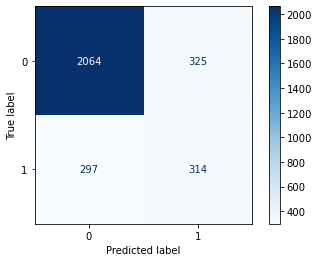

In [24]:
# Generate confusion matrix
conf_matrix_plot(decision_tree, X_test, y_test)

Notice from this confusion matrix that the model correctly predicts many true negatives. Of course, this is to be expected, given that the dataset is imbalanced in favor of negatives. When the model makes an error, it appears slightly more likely to predict a false positive than a false negative, but it's generally balanced. This is reflected in the precision and recall scores both being very close to each other. 

#### Plotting the tree

Next, let's examine the splits of the tree. We'll do this by using the `plot_tree()` function that we imported. We pass to it our fit model as well as some additional parameters. Note that if we did not set `max_depth=2`, the function would return a plot of the entire tree, all the way down to the leaf nodes. This is intractable and unnecessary. We're most interested in the splits nearest the root, because these tell us the most predictive features.

`class_names` displays what the majority class of each node is, and `filled` colors the nodes according to their majority class. 

Note that this plot represents how the tree grew from the _training data_. To make its predictions on the test data, the tree would simply pass each customer in the test data through its splits, from the root node all the way down to a leaf node.

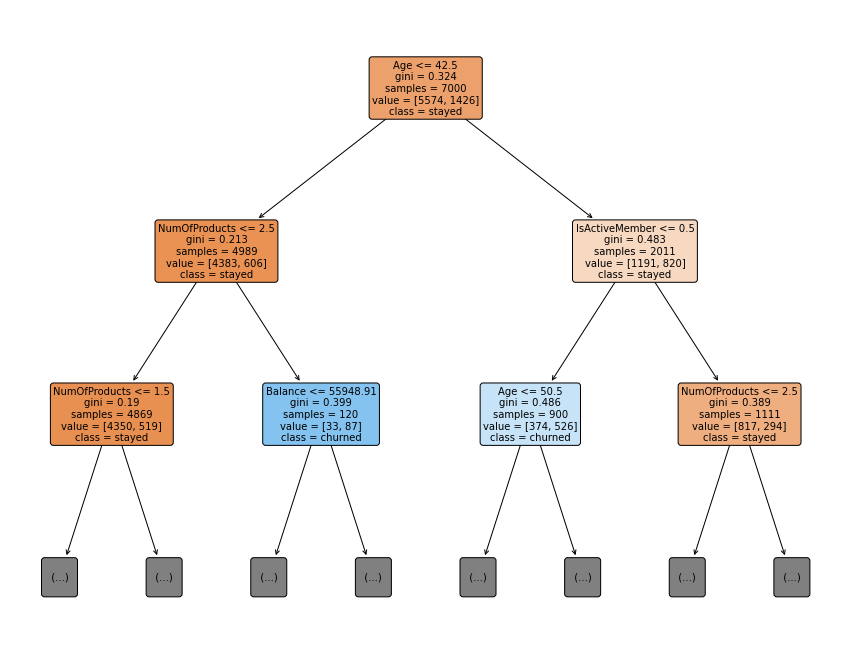

In [31]:
# Plot the tree
plt.figure(figsize=(15,12))
plot_tree(decision_tree, 
          max_depth=2, 
          fontsize=10, 
          feature_names=X.columns, 
          class_names={0:'stayed', 1:'churned'}, 
          filled=True, 
          rounded=True);
plt.show()

How do we read this plot? The first line of information in each node is the feature and split point that the model identified as being most predictive. In other words, this is the question that is being asked at that split. For our root node, the question was: _Is the customer less than or equal to 42.5 years old?_

At each node, if the answer to the question it asks is "yes," the sample would move to the child node on the left. If the answer is "no," the sample would go to the child node on the right.

`gini` refers to the node's _Gini impurity_. This is a way of measuring how "pure" a node is. The value can range from 0 to 0.5. A Gini score of 0 means there is no impurity&mdash;the node is a leaf, and all of its samples are of a single class. A score of 0.5 means the classes are all equally represented in that node.

`samples` is simply how many samples are in that node, and `value` indicates how many of each class are in the node. Returning to the root node, we have `value = [5972, 1528]`. Notice that these numbers sum to 7,500, which is the number of samples in the node. This tells us that 5,972 customers in this node stayed (y=0) and 1,528 customers churned (y=1).

Lastly, we have `class`. This tells us the majority class of the samples in each node.

</br>  

This plot tells us that, if we could only do a single split on a single variable, the one that would most help us predict whether a customer will churn is their age.

If we look at the nodes at depth one, we notice that the number of products and whether or not the customer is an active member also are both strong predictors (relative to the features we have) of whether or not they will churn. 

This is a good indication that it might be worthwhile to return to your EDA and examine these features more closely. 

Finally, it's worth noting that there is no single question that can be asked&mdash;for any feature&mdash;that would cause a majority of samples in one of the child nodes to be of class "churned." The tree must get to depth two (i.e., two questions must be asked) before this happens.

If you have successfully completed the material above, congratulations! You now understand how to use Python to construct and interpret a decision tree model. Going forward, you can start using Python to build decision trees with your own data.